Training data loaded: (1155, 43)
Validation data loaded: (370, 43)
Test data loaded: (438, 43)

Model: KNN
Validation Accuracy: 0.6675675675675675
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        92
           1       0.65      0.71      0.68        96
           2       0.58      0.48      0.52        88
           3       0.70      0.67      0.68        94

    accuracy                           0.67       370
   macro avg       0.66      0.67      0.66       370
weighted avg       0.66      0.67      0.66       370


Model: Random Forest
Validation Accuracy: 0.9972972972972973
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        92
           1       0.99      1.00      0.99        96
           2       1.00      1.00      1.00        88
           3       1.00      1.00      1.00        94

    accuracy                           1.00       370
   macro avg       1.00      1

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.38      0.86      0.53        92
           1       0.48      0.26      0.34        96
           2       0.00      0.00      0.00        88
           3       0.45      0.53      0.49        94

    accuracy                           0.42       370
   macro avg       0.33      0.41      0.34       370
weighted avg       0.33      0.42      0.34       370


Model: MLP
Validation Accuracy: 0.8513513513513513
              precision    recall  f1-score   support

           0       0.84      0.96      0.89        92
           1       0.93      0.58      0.72        96
           2       0.74      0.94      0.83        88
           3       0.95      0.94      0.94        94

    accuracy                           0.85       370
   macro avg       0.86      0.85      0.85       370
weighted avg       0.87      0.85      0.84       370


Best model: Random Forest with validation accuracy: 0.9973

Test Accuracy: 0.

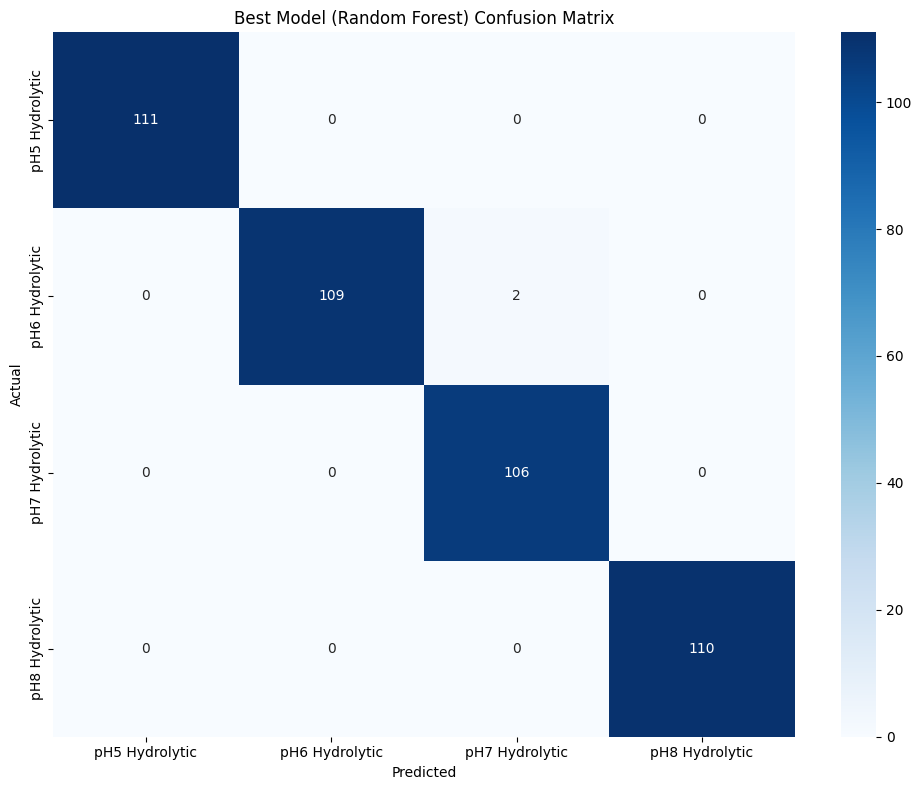

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


# --- CONFIGURATION ---
USE_ONE_HOT_TIME = True  # Set to True to use one-hot time bins instead of normalized time

# --- 1. Feature Extraction ---
def extract_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    hist = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    hist /= np.sum(hist)

    mean = np.mean(image, axis=(0, 1))
    std = np.std(image, axis=(0, 1))
    skewness = np.mean(((image - mean) / (std + 1e-6)) ** 3, axis=(0, 1))
    moments = np.concatenate([mean, std, skewness])

    return np.concatenate([hist, moments])


# --- 2. Load Images and Metadata ---
def load_images_from_folder(base_folder_path, dataset_type, max_time=140):
    """
    Load images from a specific dataset folder (train, val, or test)
    """
    X, y = [], []
    label_set = set()
    time_values = []
    time_bins = []

    # First, identify all possible labels across all datasets
    all_labels = set()
    for dataset in ['train', 'val', 'test']:
        dataset_path = os.path.join(base_folder_path, dataset)
        if not os.path.isdir(dataset_path):
            continue
            
        for time_folder in os.listdir(dataset_path):
            time_path = os.path.join(dataset_path, time_folder)
            if not os.path.isdir(time_path): 
                continue
                
            for condition_folder in os.listdir(time_path):
                if condition_folder == ".DS_Store":
                    continue
                all_labels.add(condition_folder)

    # Create a consistent label mapping across all datasets
    label_map = {label: idx for idx, label in enumerate(sorted(all_labels))}
    
    # Now load only the requested dataset
    dataset_path = os.path.join(base_folder_path, dataset_type)
    if not os.path.isdir(dataset_path):
        print(f"Warning: {dataset_type} directory not found!")
        return np.array([]), np.array([]), label_map
        
    for time_folder in os.listdir(dataset_path):
        time_path = os.path.join(dataset_path, time_folder)
        if not os.path.isdir(time_path): 
            continue

        try:
            time_value = int(time_folder.split()[0])
        except:
            continue

        normalized_time = time_value / max_time
        time_bin = time_value // 25

        for condition_folder in os.listdir(time_path):
            if condition_folder == ".DS_Store":
                continue
                
            condition_path = os.path.join(time_path, condition_folder)
            if not os.path.isdir(condition_path): 
                continue

            try:
                pH = int(condition_folder.split()[0][2:])
            except:
                pH = 0

            for filename in os.listdir(condition_path):
                img_path = os.path.join(condition_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (64, 64))
                    image_features = extract_features(img)

                    if USE_ONE_HOT_TIME:
                        time_bins.append(time_bin)
                        time_values.append((image_features, pH, condition_folder))
                    else:
                        features = np.concatenate([image_features, [normalized_time, pH]])
                        X.append(features)
                        y.append(label_map[condition_folder])

    if USE_ONE_HOT_TIME and time_bins:
        enc = OneHotEncoder(sparse_output=False)
        one_hot_times = enc.fit_transform(np.array(time_bins).reshape(-1, 1))
        for i, (image_features, pH, label) in enumerate(time_values):
            combined = np.concatenate([image_features, one_hot_times[i], [pH]])
            X.append(combined)
            y.append(label_map[label])

    return np.array(X), np.array(y), label_map


# --- 3. Train and Evaluate ---
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, label_map):
    models = {
        "KNN": KNeighborsClassifier(n_neighbors=3),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='rbf'),
        "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
    }

    best_model = None
    best_val_accuracy = 0
    best_model_name = ""

    # Train and validate models using the training and validation sets
    for name, model in models.items():
        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        val_acc = accuracy_score(y_val, val_preds)

        print(f"\nModel: {name}")
        print("Validation Accuracy:", val_acc)
        print(classification_report(y_val, val_preds))

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model = model
            best_model_name = name

    print(f"\nBest model: {best_model_name} with validation accuracy: {best_val_accuracy:.4f}")

    # Evaluate the best model on the test data
    test_preds = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    print("\nTest Accuracy:", test_acc)
    print(classification_report(y_test, test_preds))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[k for k, v in sorted(label_map.items(), key=lambda x: x[1])],
                yticklabels=[k for k, v in sorted(label_map.items(), key=lambda x: x[1])])
    plt.title(f'Best Model ({best_model_name}) Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


# --- 4. Main ---
if __name__ == "__main__":
    base_folder_path = "Split_Data"  # Folder containing 'train', 'val', and 'test' subfolders

    # Create a consistent label mapping across all datasets
    all_labels = set()
    for dataset in ['train', 'val', 'test']:
        dataset_path = os.path.join(base_folder_path, dataset)
        if not os.path.isdir(dataset_path):
            continue
            
        for time_folder in os.listdir(dataset_path):
            time_path = os.path.join(dataset_path, time_folder)
            if not os.path.isdir(time_path): 
                continue
                
            for condition_folder in os.listdir(time_path):
                if condition_folder == ".DS_Store":
                    continue
                all_labels.add(condition_folder)

    label_map = {label: idx for idx, label in enumerate(sorted(all_labels))}
    
    # Load data from each dataset separately
    X_train, y_train, _ = load_images_from_folder(base_folder_path, "train")
    X_val, y_val, _ = load_images_from_folder(base_folder_path, "val")
    X_test, y_test, _ = load_images_from_folder(base_folder_path, "test")

    print("Training data loaded:", X_train.shape)
    print("Validation data loaded:", X_val.shape)
    print("Test data loaded:", X_test.shape)

    # Train and evaluate the model using the train, val, and test sets
    if len(X_train) > 0 and len(X_val) > 0 and len(X_test) > 0:
        train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, label_map)
    else:
        print("Error: One or more datasets are empty. Please check your folder structure.")